### 1) Setup & Imports
This section prepares the Python environment for the validation task. It loads essential libraries (pandas, numpy, matplotlib and sentence transformers). 
The code suppresses warning messages that would clutter the output and explicitly tells the system to use my CPU rather than GPU.


In [1]:
# Optional (uncomment if you need to install UMAP from within Jupyter)
# !pip install umap-learn --quiet

import os
import warnings
from pathlib import Path

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sentence_transformers import SentenceTransformer

# Quieter logs/warnings
os.environ["HF_HUB_DISABLE_SYMLINKS_WARNING"] = "1"
warnings.filterwarnings("ignore")

# Use CPU explicitly (GPU is not required)
DEVICE = "cpu"

# Pretty printing of arrays / data
np.set_printoptions(precision=4, suppress=True)
pd.set_option("display.max_colwidth", 140)

print("Environment ready (CPU mode).")


c:\Users\Kyle\anaconda3\envs\capstone\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Environment ready (CPU mode).


### 2) Load the Data
This reads the KSA extraction CSV file and prepares it for analysis. First, it standardizes all column names (removes spaces, converts to lowercase) to prevent errors. Then it filters to keep only "skill" type records since we're validating skills specifically. The code includes safety features that handle missing data gracefully - if a column like "evidence_snippet" doesn't exist or has empty values, it fills them with blank strings rather than crashing. It also searches for ESCO tags under various possible column names (esco_tag, esco, skill_tag, etc.) to handle different file formats.

In [2]:
# --- Configure your input path here ---
DATA_PATH = Path(r"C:\Users\Kyle\OneDrive\Desktop\Capstone\fall-2025-group6\src\Data\Manual Extraction\ksa_enhanced\ksa_extractions_enhanced_cleaned.csv")

# Load
df = pd.read_csv(DATA_PATH)

# Normalize column names for safety
df = df.rename(columns={c: c.strip().lower().replace(" ", "_") for c in df.columns})

# Keep skills only
skills = df[df["type"].str.lower() == "skill"].copy()

# Safe getters
skills["text"] = skills["text"].fillna("").astype(str)
skills["evidence_snippet"] = skills.get("evidence_snippet", "").fillna("").astype(str)
skills["afsc"] = skills.get("afsc", "").astype(str)

# ESCO tag may be under different names; unify into one column
esco_col = next((c for c in ["esco_tag", "esco", "skill_tag", "skilltag", "esco_label"] if c in skills.columns), None)
skills["esco_tag"] = skills[esco_col].fillna("").astype(str) if esco_col else ""

print(f"Loaded {len(skills)} skill rows for validation.")
skills.head(3)


Loaded 65 skill rows for validation.


,job_id,description,text,knowledge_required,task_abilities,skill_tag,confidence,type,description,afsc,title,category,evidence_snippet,source_method,doc_id,section,page,parent_skills,review_status,esco_tag
7,manual::11F3,"AFSC 11F4*, Staff AFSC 11F3*, Flight Lead AFSC 11F2*, Wingman AFSC 11F1*, Entry/Student FIGHTER PILOT (Changed 30 Apr 23) 1. Specialty S...",train air force crew,[],[],ESCO.2859,0.593154,skill,"AFSC 11F4*, Staff AFSC 11F3*, Flight Lead AFSC 11F2*, Wingman AFSC 11F1*, Entry/Student FIGHTER PILOT (Changed 30 Apr 23) 1. Specialty S...",11F3,FIGHTER PILOT,Operations,,laiser,NaN,NaN,NaN,NaN,reviewed,ESCO.2859
8,manual::11F3,"AFSC 11F4*, Staff AFSC 11F3*, Flight Lead AFSC 11F2*, Wingman AFSC 11F1*, Entry/Student FIGHTER PILOT (Changed 30 Apr 23) 1. Specialty S...",military aviation,[],[],ESCO.6338,0.588426,skill,"AFSC 11F4*, Staff AFSC 11F3*, Flight Lead AFSC 11F2*, Wingman AFSC 11F1*, Entry/Student FIGHTER PILOT (Changed 30 Apr 23) 1. Specialty S...",11F3,FIGHTER PILOT,Operations,,laiser,NaN,NaN,NaN,NaN,reviewed,ESCO.6338
9,manual::11F3,"AFSC 11F4*, Staff AFSC 11F3*, Flight Lead AFSC 11F2*, Wingman AFSC 11F1*, Entry/Student FIGHTER PILOT (Changed 30 Apr 23) 1. Specialty S...",air force operations,[],[],ESCO.9897,0.553011,skill,"AFSC 11F4*, Staff AFSC 11F3*, Flight Lead AFSC 11F2*, Wingman AFSC 11F1*, Entry/Student FIGHTER PILOT (Changed 30 Apr 23) 1. Specialty S...",11F3,FIGHTER PILOT,Operations,,laiser,NaN,NaN,NaN,NaN,reviewed,ESCO.9897


### 3) Configure the Embedding Model
This loads a pre-trained language model (E5-base-v2) that converts text into mathematical vectors (embeddings). These vectors capture the meaning of text in 768 dimensions, allowing us to measure how similar two pieces of text are. The helper function adds a "passage:" prefix to each text (which improves the model's performance) and normalizes the vectors so their length equals 1. This normalization trick means we can use simple dot products to calculate cosine similarity later.

In [3]:
MODEL_NAME = "intfloat/e5-base-v2"
model = SentenceTransformer(MODEL_NAME, device=DEVICE)

def embed(texts):
    """Return L2-normalized embeddings for a list of strings."""
    if not isinstance(texts, (list, tuple)):
        texts = [texts]
    # E5 performs best with prefix formatting
    texts = [f"passage: {t}" if t and not t.startswith("passage:") else (t or "") for t in texts]
    embs = model.encode(texts, normalize_embeddings=True, batch_size=32, convert_to_numpy=True)
    return embs


### 4) Compute Cosine Similarities
This is the core validation step. The code converts three text elements into vectors: the extracted skill, its source evidence, and its ESCO label. Then it calculates how similar these vectors are using cosine similarity (ranging from -1 to 1, where 1 means identical meaning). High similarity between skill and evidence confirms the extraction is well-grounded in the source text. High similarity between skill and ESCO validates proper taxonomy alignment. The describe() function shows statistics like mean and standard deviation to assess overall quality.

In [4]:
# Prepare text lists
skill_text = skills["text"].tolist()
evidence_text = skills["evidence_snippet"].tolist()
esco_text = skills["esco_tag"].tolist()

# Compute embeddings
emb_skill = embed(skill_text)
emb_evid  = embed(evidence_text)
emb_esco  = embed(esco_text)

# Cosine similarity (dot product of normalized vectors)
skills["sim_skill_evidence"] = (emb_skill * emb_evid).sum(axis=1)
skills["sim_skill_esco"]     = (emb_skill * emb_esco).sum(axis=1)

print("=== Similarity (Skill vs Evidence) ===")
print(skills["sim_skill_evidence"].describe(), "\n")

print("=== Similarity (Skill vs ESCO) ===")
print(skills["sim_skill_esco"].describe())


=== Similarity (Skill vs Evidence) ===
count    65.000000
mean      0.747818
std       0.019423
min       0.718716
25%       0.731501
50%       0.748496
75%       0.754544
max       0.816520
Name: sim_skill_evidence, dtype: float64 

=== Similarity (Skill vs ESCO) ===
count    65.000000
mean      0.741805
std       0.012779
min       0.704031
25%       0.736576
50%       0.742479
75%       0.746878
max       0.770654
Name: sim_skill_esco, dtype: float64


### 5) Visualize Skills (UMAP or PCA Fallback)
This creates a 2D scatter plot of the skills to visually check if related skills cluster together. UMAP (or PCA as backup) compresses the embeddings down to just 2 dimensions while preserving relationships. Each point represents one skill, colored by its AFSC code. If skills from the same AFSC group together, it confirms the embeddings capture meaningful patterns. Good clustering suggests your extraction pipeline maintains semantic coherence.

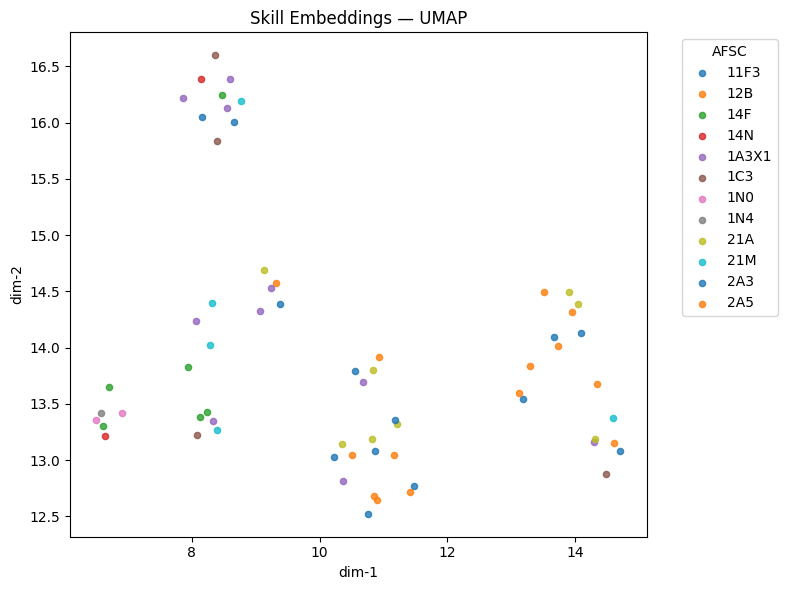

In [5]:
# Try UMAP first, then fall back to PCA
try:
    import umap
    reducer = umap.UMAP(n_neighbors=30, min_dist=0.05, random_state=42)
    coords = reducer.fit_transform(emb_skill)
    method = "UMAP"
except Exception:
    from sklearn.decomposition import PCA
    reducer = PCA(n_components=2, random_state=42)
    coords = reducer.fit_transform(emb_skill)
    method = "PCA (fallback)"

skills["x"] = coords[:, 0]
skills["y"] = coords[:, 1]

plt.figure(figsize=(8, 6))
for afsc, sub in skills.groupby("afsc"):
    plt.scatter(sub["x"], sub["y"], s=20, alpha=0.8, label=afsc)

plt.title(f"Skill Embeddings — {method}")
plt.xlabel("dim-1")
plt.ylabel("dim-2")
plt.legend(title="AFSC", bbox_to_anchor=(1.05, 1), loc="upper left")
plt.tight_layout()
plt.show()


### 6) Threshold Flags, Outliers, and Sanity Checks
This section identifies potential quality issues by flagging skills with unusually low similarity scores. The thresholds (0.45 for evidence, 0.35 for ESCO) are conservative - anything below will likely need manual review. The code displays the 5 worst-matching skill-evidence pairs so you can inspect what's causing low similarities (often it's just very short text or formatting issues). If you have LAiSER confidence scores, it checks whether high confidence correlates with high similarity, validating the extraction model's self-assessment.


In [6]:
# Conservative “possible issue” thresholds (tune as needed)
THRESH_EVID = 0.45
THRESH_ESCO = 0.35

skills["flag_low_evidence"] = skills["sim_skill_evidence"] < THRESH_EVID
skills["flag_low_esco"]     = skills["sim_skill_esco"]     < THRESH_ESCO

print(f"Potential low evidence sims (< {THRESH_EVID:.2f}): {skills['flag_low_evidence'].sum()}")
print(f"Potential low ESCO sims    (< {THRESH_ESCO:.2f}): {skills['flag_low_esco'].sum()}")

# Show 5 weakest matches for evidence (for explainability)
print("\nWorst 5 skill↔evidence pairs:")
cols = ["afsc", "text", "evidence_snippet", "sim_skill_evidence"]
display(skills.nsmallest(5, "sim_skill_evidence")[cols])

# Optional: check correlation with LAiSER confidence if present
if "confidence" in skills.columns:
    try:
        corr = skills["confidence"].astype(float).corr(skills["sim_skill_evidence"])
        print(f"\nCorrelation (LAiSER confidence vs Skill↔Evidence sim): {corr:.3f}")
    except Exception:
        print("\nCould not compute correlation with 'confidence' (non-numeric contents).")


Potential low evidence sims (< 0.45): 0
Potential low ESCO sims    (< 0.35): 0

Worst 5 skill↔evidence pairs:


,afsc,text,evidence_snippet,sim_skill_evidence
133,21A,supervise maintenance activities in airports,,0.718716
165,2A3,supervise maintenance activities in airports,,0.718716
185,2A5,supervise maintenance activities in airports,,0.718716
66,1A3X1,apply military aviation regulations,,0.721616
134,21A,apply military aviation regulations,,0.721616



Correlation (LAiSER confidence vs Skill↔Evidence sim): -0.168


### 7) Sensitivity Sweep
This generates a quality report showing what percentage of skills would "pass" at different similarity thresholds. For example, it might show that 100% of skills have similarity >0.30, but only 85% have similarity >0.70. This helps justify my chosen thresholds and understand the quality distribution.

In [7]:
import numpy as np

print("Evidence threshold sweep:")
for t in np.arange(0.30, 0.81, 0.05):
    pct = (skills["sim_skill_evidence"] >= t).mean() * 100
    print(f"  ≥ {t:.2f}: {pct:5.1f}% pass")

print("\nESCO threshold sweep:")
for t in np.arange(0.30, 0.81, 0.05):
    pct = (skills["sim_skill_esco"] >= t).mean() * 100
    print(f"  ≥ {t:.2f}: {pct:5.1f}% pass")


Evidence threshold sweep:
  ≥ 0.30: 100.0% pass
  ≥ 0.35: 100.0% pass
  ≥ 0.40: 100.0% pass
  ≥ 0.45: 100.0% pass
  ≥ 0.50: 100.0% pass
  ≥ 0.55: 100.0% pass
  ≥ 0.60: 100.0% pass
  ≥ 0.65: 100.0% pass
  ≥ 0.70: 100.0% pass
  ≥ 0.75:  36.9% pass
  ≥ 0.80:   3.1% pass

ESCO threshold sweep:
  ≥ 0.30: 100.0% pass
  ≥ 0.35: 100.0% pass
  ≥ 0.40: 100.0% pass
  ≥ 0.45: 100.0% pass
  ≥ 0.50: 100.0% pass
  ≥ 0.55: 100.0% pass
  ≥ 0.60: 100.0% pass
  ≥ 0.65: 100.0% pass
  ≥ 0.70: 100.0% pass
  ≥ 0.75:  21.5% pass
  ≥ 0.80:   0.0% pass


### 8) Save Embeddings
This saves all the computed vectors to a compressed numpy file.

In [8]:
EMB_OUT = DATA_PATH.parent / "embeddings_e5_base_v2.npz"
np.savez(
    EMB_OUT,
    skill=emb_skill,
    evidence=emb_evid,
    esco=emb_esco,
)
print(f"Saved embeddings to {EMB_OUT}")


Saved embeddings to C:\Users\Kyle\OneDrive\Desktop\Capstone\fall-2025-group6\src\Data\Manual Extraction\ksa_enhanced\embeddings_e5_base_v2.npz


### 9) Export Validation CSV
This creates a final CSV report containing your validation results. It includes the original skill text, evidence, and ESCO tags alongside the computed similarity scores and quality flags. The code uses a unified "esco_export" column to avoid crashes from naming inconsistencies. This CSV serves the your validation audit trail for stakeholders, for further analysis, or reference it when discussing extraction quality.

In [9]:
OUT_PATH = DATA_PATH.parent / "laiser_similarity_validation.csv"

# Create a stable ESCO export column (whatever you detected earlier)
skills["esco_export"] = skills["esco_tag"]

cols_out = [
    "afsc",
    "text",
    "evidence_snippet",
    "esco_export",
    "sim_skill_evidence",
    "sim_skill_esco",
    "flag_low_evidence",
    "flag_low_esco",
]

skills.to_csv(OUT_PATH, index=False, columns=cols_out)
print(f"Exported validation results to {OUT_PATH}")


Exported validation results to C:\Users\Kyle\OneDrive\Desktop\Capstone\fall-2025-group6\src\Data\Manual Extraction\ksa_enhanced\laiser_similarity_validation.csv
